# Import Libraries and Explore Data



In [2]:
import os
import pathlib
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
import librosa
import librosa.display
import random
import concurrent.futures
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [1]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/google-speech-commands/LICENSE
/kaggle/input/google-speech-commands/testing_list.txt
/kaggle/input/google-speech-commands/README.md
/kaggle/input/google-speech-commands/validation_list.txt
/kaggle/input/google-speech-commands/no/97f4c236_nohash_3.wav
/kaggle/input/google-speech-commands/no/6f3458b3_nohash_1.wav
/kaggle/input/google-speech-commands/no/cb2929ce_nohash_3.wav
/kaggle/input/google-speech-commands/no/ad63d93c_nohash_1.wav
/kaggle/input/google-speech-commands/no/aeb99b1c_nohash_1.wav
/kaggle/input/google-speech-commands/no/c08585c1_nohash_4.wav
/kaggle/input/google-speech-commands/no/9d32f10a_nohash_0.wav
/kaggle/input/google-speech-commands/no/01648c51_nohash_1.wav
/kaggle/input/google-speech-commands/no/df1d5024_nohash_2.wav
/kaggle/input/google-speech-commands/no/e0315cf6_nohash_1.wav
/kaggle/input/google-speech-commands/no/28497c5b_nohash_1.wav
/kaggle/input/google-speech-commands/no/c22d3f18_nohash_0.wav
/kaggle/input/google-speech-commands/no/d90b4138_noha

# Set Dataset Path and Load File Lists



In [3]:
!ls /kaggle/input/

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


google-speech-commands


In [ ]:
# Set dataset directory
data_dir = '/kaggle/input/google-speech-commands'  # replace with actual path

# Read testing and validation file lists
with open(os.path.join(data_dir, 'testing_list.txt'), 'r') as f:
    test_files = f.read().splitlines()
    
with open(os.path.join(data_dir, 'validation_list.txt'), 'r') as f:
    val_files = f.read().splitlines()

# Load background noise files
noise_dir = os.path.join(data_dir, '_background_noise_')
noise_files = [os.path.join(noise_dir, f) for f in os.listdir(noise_dir) if f.endswith('.wav')]

# Load and Plot Sample Audio Waveform



Sample rate: 16000, Audio duration: 1.00 seconds


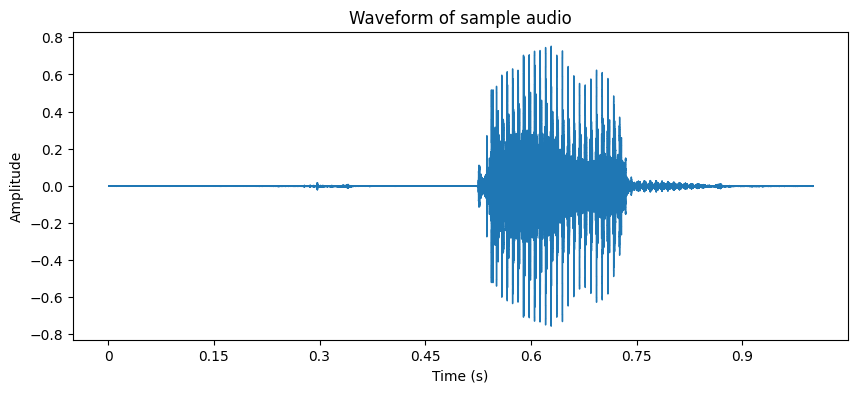

In [4]:
# Inspecting an example audio file
sample_file = os.path.join(data_dir, 'bed', '00176480_nohash_0.wav') 

# Load audio file
audio, sr = librosa.load(sample_file, sr=None)
print(f"Sample rate: {sr}, Audio duration: {len(audio) / sr:.2f} seconds")

# Display waveform
plt.figure(figsize=(10, 4))
librosa.display.waveshow(audio, sr=sr)
plt.title("Waveform of sample audio")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

# MFCC Extraction Function



In [ ]:
# Parameters
target_shape = (64, 64)  # Resize to 64x64 for CNN input

def extract_mfcc(file_path, target_shape=target_shape):
    # Load the audio file
    audio, sr = librosa.load(file_path, sr=None)
    
    # Extract MFCC features
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)  # 40 MFCC coefficients
    
    # Resize to target shape
    mfcc_resized = librosa.util.fix_length(mfcc, size=target_shape[1], axis=1)
    mfcc_resized = np.resize(mfcc_resized, target_shape)
    
    # Normalize values to the range [0, 1]
    mfcc_normalized = (mfcc_resized - np.min(mfcc_resized)) / (np.max(mfcc_resized) - np.min(mfcc_resized))
    
    return mfcc_normalized

In [5]:
# Example usage on one file
sample_mfcc = extract_mfcc(sample_file)
print("MFCC shape:", sample_mfcc.shape)

MFCC shape: (64, 64)


# Audio Augmentation Techniques
Enhancing audio data through common methods to improve model robustness:

- **Background Noise**  
  Adding random noise to simulate real-world conditions.

- **Pitch Shifting**  
  Modifying the pitch to vary the audio's tone.


In [ ]:
def add_background_noise(audio, sr, noise_files, noise_level=0.1):
    # Randomly select a noise file and load it
    noise_file = random.choice(noise_files)
    noise_audio, _ = librosa.load(noise_file, sr=sr)
    
    # Ensure noise is the same length as audio
    if len(noise_audio) > len(audio):
        noise_audio = noise_audio[:len(audio)]
    else:
        noise_audio = np.pad(noise_audio, (0, max(0, len(audio) - len(noise_audio))), 'wrap')
    
    # Overlay noise with given noise level
    augmented_audio = audio + noise_level * noise_audio
    return augmented_audio

def pitch_shift(audio, sr, semitones=1):
    # Randomly shift pitch within the range [-semitones, +semitones]
    shift = random.uniform(-semitones, semitones)
    augmented_audio = librosa.effects.pitch_shift(audio, sr=sr, n_steps=shift)
    return augmented_audio

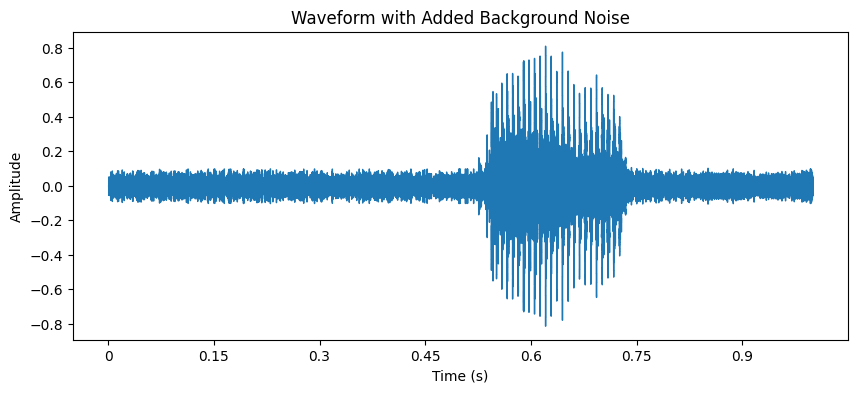

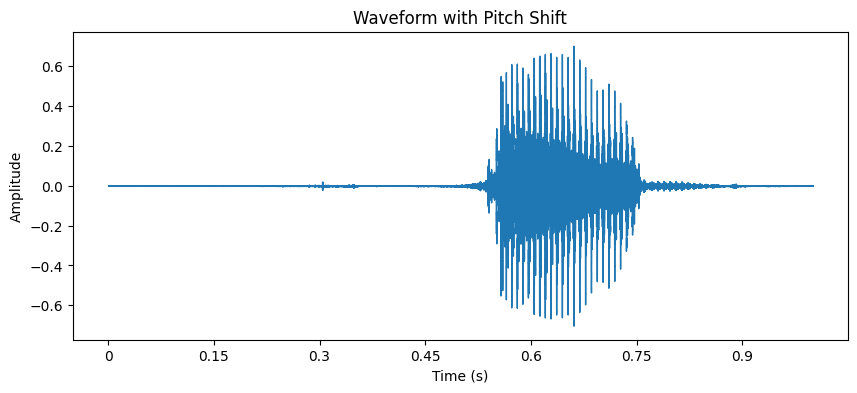

In [9]:
# Example usage
sample_audio, sample_sr = librosa.load(sample_file, sr=None)

# Add background noise
augmented_audio_noise = add_background_noise(sample_audio, sample_sr, noise_files)

# Shift pitch
augmented_audio_pitch = pitch_shift(sample_audio, sample_sr)

# Display the waveform of augmented audio with noise
plt.figure(figsize=(10, 4))
librosa.display.waveshow(augmented_audio_noise, sr=sample_sr)
plt.title("Waveform with Added Background Noise")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

# Display the waveform of pitch-shifted audio
plt.figure(figsize=(10, 4))
librosa.display.waveshow(augmented_audio_pitch, sr=sample_sr)
plt.title("Waveform with Pitch Shift")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

# Splitting Dataset into Train, Val, and Test






In [ ]:
# Collect all file paths and labels
all_paths = []
all_labels = []

# Split paths and labels into training, validation and testing sets
train_paths = []
train_labels = []
val_paths = []
val_labels = []
test_paths = []
test_labels = []

In [8]:
# Loop through each folder in the dataset directory to get file paths and labels
for label in os.listdir(data_dir):
    label_dir = os.path.join(data_dir, label)
    if os.path.isdir(label_dir) and label != '_background_noise_':
        for file_name in os.listdir(label_dir):
            file_path = os.path.join(label, file_name)  # Use relative paths as in val/test files
            all_paths.append(os.path.join(data_dir, file_path))
            all_labels.append(label)

for path, label in zip(all_paths, all_labels):
    relative_path = os.path.relpath(path, data_dir)  # Match format in validation/test lists
    if relative_path in val_files:
        val_paths.append(path)
        val_labels.append(label)
    else:
        train_paths.append(path)
        train_labels.append(label)

for path, label in zip(all_paths, all_labels):
    relative_path = os.path.relpath(path, data_dir)  # Match format in testing_list.txt
    if relative_path in test_files:
        test_paths.append(path)
        test_labels.append(label)

# Define & Apply Audio Augmentation Functions



In [ ]:
# Define paths and parameters
target_shape = (64, 64)
augmentation_prob = 0.5  # Probability of applying each augmentation

In [ ]:
# Define augmentation functions
def add_background_noise(audio, sr, noise_files, noise_level=0.1):
    noise_file = random.choice(noise_files)
    noise_audio, _ = librosa.load(noise_file, sr=sr)
    if len(noise_audio) > len(audio):
        noise_audio = noise_audio[:len(audio)]
    else:
        noise_audio = np.pad(noise_audio, (0, max(0, len(audio) - len(noise_audio))), 'wrap')
    augmented_audio = audio + noise_level * noise_audio
    return augmented_audio

def pitch_shift(audio, sr, semitones=1):
    shift = random.uniform(-semitones, semitones)
    augmented_audio = librosa.effects.pitch_shift(audio, sr=sr, n_steps=shift)
    return augmented_audio

def load_and_augment_audio(file_path):
    audio, sr = librosa.load(file_path, sr=None)
    if random.random() < augmentation_prob:
        audio = add_background_noise(audio, sr, noise_files)
    if random.random() < augmentation_prob:
        audio = pitch_shift(audio, sr)
    return audio, sr

def process_single_file(file_path, label):
    audio, sr = load_and_augment_audio(file_path)
    mfcc_features = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
    mfcc_resized = librosa.util.fix_length(mfcc_features, size=target_shape[1], axis=1)
    mfcc_resized = np.resize(mfcc_resized, target_shape)
    mfcc_normalized = (mfcc_resized - np.min(mfcc_resized)) / (np.max(mfcc_resized) - np.min(mfcc_resized))
    return mfcc_normalized, label

def prepare_dataset_parallel(file_paths, labels):
    X, y = [], []
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = executor.map(process_single_file, file_paths, labels)
        for mfcc_features, label in results:
            X.append(mfcc_features)
            y.append(label)
    return np.array(X), np.array(y)

In [10]:
# Prepare training and validation sets
X_train, y_train = prepare_dataset_parallel(train_paths, train_labels)
X_val, y_val = prepare_dataset_parallel(val_paths, val_labels)
X_test, y_test = prepare_dataset_parallel(test_paths, test_labels)

print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)

Training data shape: (57923, 64, 64)
Validation data shape: (6798, 64, 64)


# Encode Labels for Training and Validation Sets


In [11]:
# Initialize label encoder
label_encoder = LabelEncoder()

# Fit label encoder on training labels and transform both training and validation labels
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

print("Encoded labels for training set:", y_train_encoded[:5])
print("Encoded labels for validation set:", y_val_encoded[:5])

Encoded labels for training set: [14 14 14 14 14]
Encoded labels for validation set: [14 14 14 14 14]


# Save/Load Processed Data for Train and Val


In [13]:
# Save processed data to /kaggle/working directory
np.save('/kaggle/working/X_train.npy', X_train)
np.save('/kaggle/working/y_train_encoded.npy', y_train_encoded)
np.save('/kaggle/working/X_val.npy', X_val)
np.save('/kaggle/working/y_val_encoded.npy', y_val_encoded)

print("Data saved successfully in /kaggle/working directory.")

Data saved successfully in /kaggle/working directory.


In [ ]:
# Load processed data from /kaggle/working directory
X_train = np.load('/kaggle/working/X_train.npy')
y_train_encoded = np.load('/kaggle/working/y_train_encoded.npy')
X_val = np.load('/kaggle/working/X_val.npy')
y_val_encoded = np.load('/kaggle/working/y_val_encoded.npy')

print("Data loaded successfully from /kaggle/working directory.")
print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)

# Define, Compile & Train CNN Model for Audio Classification



In [ ]:
# Define the CNN model
def create_model(input_shape, num_classes):
    model = models.Sequential()
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Conv2D(512, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

In [19]:
# Re-create and compile the model
model = create_model(input_shape, num_classes)

model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])


# Display model architecture
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 62, 62, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 31, 31, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 29, 29, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 6, 6, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 2, 2, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 30)             │         7,710 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,085,918 (7.96 MB)

 Trainable params: 2,083,998 (7.95 MB)

 Non-trainable params: 1,920 (7.50 KB)

# Applying Early Stopping & LR Reduction

In [20]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)

callbacks = [early_stopping, reduce_lr]

In [21]:
# Reshape data to include channel dimension (since the model expects 3D input)
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]

# Train the model
history = model.fit(
    X_train, y_train_encoded,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, y_val_encoded),
    callbacks=callbacks
)

Epoch 1/30
1811/1811 ━━━━━━━━━━━━━━━━━━━━ 35s 15ms/step - accuracy: 0.0948 - loss: 3.2460 - val_accuracy: 0.5462 - val_loss: 1.5919 - learning_rate: 1.0000e-04
Epoch 2/30
1811/1811 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.5578 - loss: 1.4653 - val_accuracy: 0.7708 - val_loss: 0.7737 - learning_rate: 1.0000e-04
Epoch 3/30
1811/1811 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.7376 - loss: 0.8712 - val_accuracy: 0.7607 - val_loss: 0.8247 - learning_rate: 1.0000e-04
Epoch 4/30
1811/1811 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.7972 - loss: 0.6655 - val_accuracy: 0.8021 - val_loss: 0.6673 - learning_rate: 1.0000e-04
Epoch 5/30
1811/1811 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.8376 - loss: 0.5389 - val_accuracy: 0.7908 - val_loss: 0.6790 - learning_rate: 1.0000e-04
Epoch 6/30
1811/1811 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.8642 - loss: 0.4558 - val_accuracy: 0.8302 - val_loss: 0.5606 - learning_rate: 1.0000e-04
Epoch 7/30
1811/1811 ━━━━━━━━━━━━━━━━━━━

# Visualize Model Performance




In [ ]:
# Plot training & validation accuracy and loss
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Training and Validation Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    
    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Training and Validation Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    plt.show()

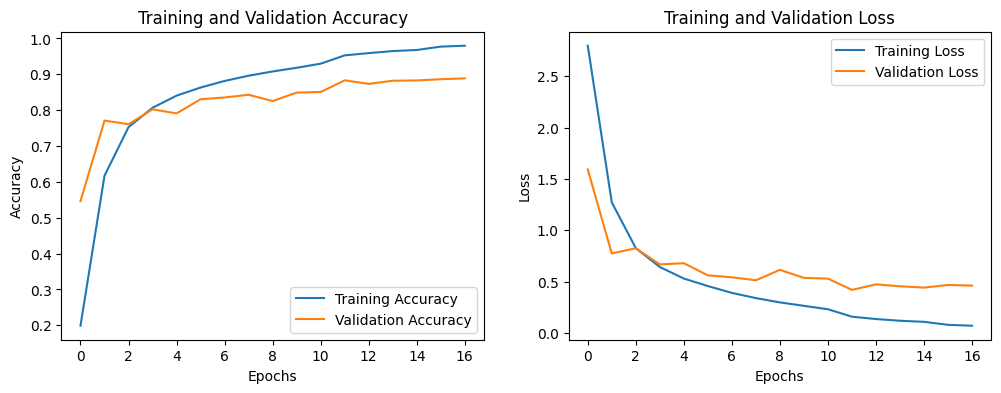

In [22]:
# Plot the training history
plot_history(history)

# Model Evaluation


In [ ]:
# Create a mapping from class labels to their encoded values
class_indices = {label: idx for idx, label in enumerate(label_encoder.classes_)}

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class labels
y_test_classes = np.array([class_indices[label] for label in y_test])  # Convert true labels to numeric

# Calculate metrics
test_accuracy = accuracy_score(y_test_classes, y_pred_classes)
test_precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
test_recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
test_f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')

214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test Accuracy: 0.9342
Test Precision: 0.9359
Test Recall: 0.9342
Test F1 Score: 0.9344


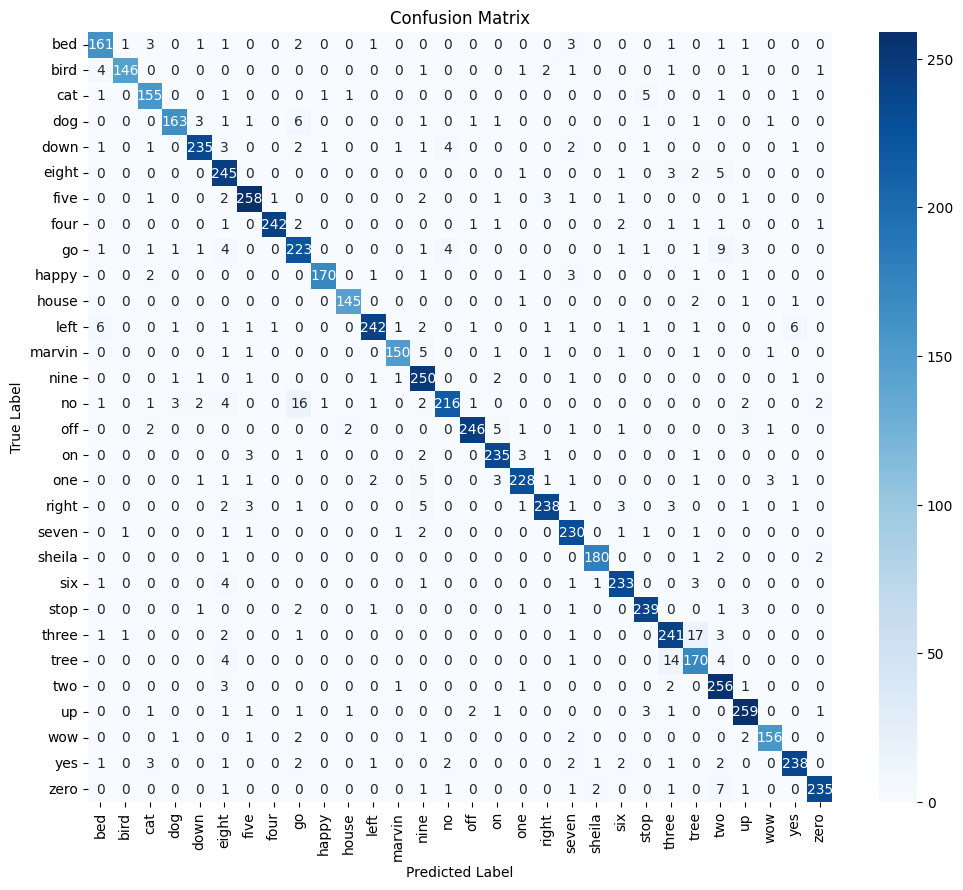

In [25]:
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_indices.keys(), yticklabels=class_indices.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Save the Trained Model


In [26]:
# Save the trained model
model.save('/kaggle/working/speech_command_cnn_model.h5')
print("Model saved successfully.")

Model saved successfully.
